### What is transfer learning?
Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 
### An example 
For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.'


![Transfer Learning](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)


### Explaining it in simple terms, or atleast trying to 

- With transfer learning, we basically try to exploit what has been learned in one task to improve generalization in another. We transfer the weights that a network has learned at "task A" to a new "task B."



- The general idea is to use the knowledge a model has learned from a task with a lot of available labeled training data in a new task that doesn't have much data. 
- Instead of starting the learning process from scratch, we start with patterns learned from solving a related task.

- Transfer learning is mostly used in computer vision and natural language processing tasks like sentiment analysis due to the huge amount of computational power required.

- Transfer learning isn't really a machine learning technique, but can be seen as a "design methodology" within the field, for example, active learning. 
- It is also not an exclusive part or study-area of machine learning. Nevertheless, it has become quite popular in combination with neural networks that require huge amounts of data and computational power.

![](https://cdn.builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/AGI-transfer-learning_0.png)



##### I will be following the code done on the same dataset by [Ahmed Saied](https://www.kaggle.com/phylake1337) explained in the link [The Code](https://www.kaggle.com/phylake1337/0-18-loss-simple-feature-extractors/notebook)


### Introduction

* This kernel is a detailed guide for transfer learning on Dog Breeds problem, it's all about learning a new technique, evaluate it using only Kaggle training set without cheating.

* The aim of this kernel is to show you how to use pre-trained CNN models as feature extractors, which one of the most effective transfer learning techniques.

* A reasonable question comes to your mind, 'Wait, why do we have to use this technique, why don't we just use regular transfer learning ?', if you try to do so, you will figure out that the problem is pretty hard for a single model to handle (you would get higher loss and less accuracy).

* It's even hard for humankind to distinguish between 120 dog breeds!, single poor CNN would struggle.

### Explanation

- Take look at general CNN architecture for image classification in two main parts, “feature extractor” that based on conv-layers, and “classifier” which usually based on fully connected layers:
- Simply, feature extractor could be created as follow > (Feature Extractor = Pretrained Model - Late Fully Connected Layers)

- For example, InceptionV3 feature extractor (without last FC layer) outputs 2048 vector for each image sample, each value represent a certain feature of dog image (Coded in numerical values of course), like Dog color?, How big is his head?, Shape of the eyes?, length of the tale?, Size? .. etc

- Hence, more "different" feature extractors mean more features to be used to determine which breed does this dog belong.

- So our strategy goes as the following,

 - Create 4 feature extractor using different pre-trained CNN models
 - Extract features from raw data and stacks the features together.
 - Use a simple DNN with one dense layer and a heavy dropout layer to figure out patterns in the feature extracted from the data.
 - The code is simple, concise and fully-commented. Feel free to ask for help / more info / more explanation in the comments.

- Finally if this kernel helps you somehow, kindly don't forget to leave a little upvote.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 

import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

2021-09-18 08:07:55.426907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def get_num_files(path):
    '''
    Counts the number of files in a folder.
    '''
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [3]:
#Data Paths
train_dir = '/kaggle/input/dog-breed-identification/train'
test_dir = '/kaggle/input/dog-breed-identification/test'
#Count/Print train and test samples.
data_size = get_num_files(train_dir)
test_size = get_num_files(test_dir)
print('Data samples size: ', data_size)
print('Test samples size: ', test_size)

Data samples size:  10222
Test samples size:  10357


In [4]:
#Read train labels.
labels_dataframe = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
#Read sample_submission file to be modified by pridected labels.
sample_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
#Incpect labels_dataframe.
labels_dataframe.head(1)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull


In [5]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)

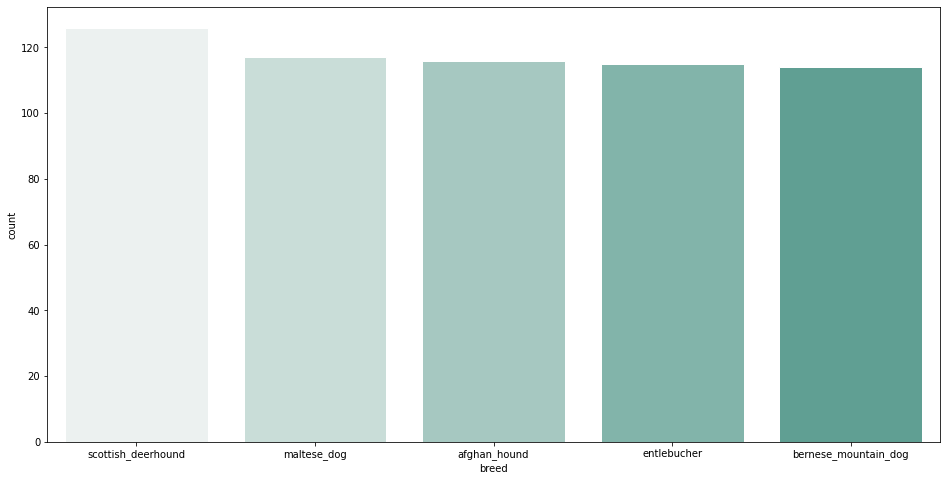

In [6]:
import seaborn as sns


sns.color_palette("light:#5A9", as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="breed", data=labels_dataframe,palette="light:#5A9",order=labels_dataframe.breed.value_counts().iloc[:5].index)

In [7]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [8]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Risize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [9]:
#img_size chosen to be 331 to suit the used architectures.
img_size = (331,331,3)
X, y = images_to_array(train_dir, labels_dataframe, img_size)

100%|██████████| 10222/10222 [01:16<00:00, 133.93it/s]


Ouptut Data Size:  (10222, 331, 331, 3)
Ouptut Label Size:  (10222, 120)


In [10]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [11]:
# Extract features using InceptionV3 as extractor.
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

2021-09-18 08:09:43.528034: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-18 08:09:43.530370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-18 08:09:43.583269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-18 08:09:43.583928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-18 08:09:43.584009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-18 08:09:43.607498: I tensorflow/stream_executor/platform/def

87916544/87910968 [==============================] - 0s 0us/step


2021-09-18 08:09:48.244657: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.
2021-09-18 08:09:50.808944: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-18 08:09:50.818827: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz
2021-09-18 08:09:52.124011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-18 08:09:57.509926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-18 08:09:58.151328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


160/160 [==============================] - 33s 155ms/step
Feature maps shape:  (10222, 2048)


In [12]:
# Extract features using Xception as extractor.
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

83689472/83683744 [==============================] - 1s 0us/step


2021-09-18 08:10:27.078806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.


160/160 [==============================] - 49s 299ms/step
Feature maps shape:  (10222, 2048)


In [13]:
# Extract features using ResNet152V2 as extractor.
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
resnet_preprocessor = preprocess_input
resnet_features = get_features(ResNet152V2,
                               resnet_preprocessor,
                               img_size, X)

234553344/234545216 [==============================] - 1s 0us/step


2021-09-18 08:11:25.545410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.


160/160 [==============================] - 80s 485ms/step
Feature maps shape:  (10222, 2048)


In [14]:
# Extract features using NASNetLarge as extractor.
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

343613440/343610240 [==============================] - 2s 0us/step


2021-09-18 08:13:00.680408: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.


160/160 [==============================] - 177s 1s/step
Feature maps shape:  (10222, 4032)


In [15]:
# Extract features using InceptionResNetV2 as extractor.
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

219062272/219055592 [==============================] - 1s 0us/step


2021-09-18 08:16:09.067452: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3359797626 exceeds 10% of free system memory.


160/160 [==============================] - 65s 380ms/step
Feature maps shape:  (10222, 1536)


In [16]:
#It's a good habit to free up some RAM memory.
#X variable won't be needed anymore, so let's get rid of it.
del X

In [17]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 resnet_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 11712)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [19]:
#Prepare DNN model
dnn = tensorflow.keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/60
72/72 [==============================] - 1s 12ms/step - loss: 1.9930 - accuracy: 0.6089 - val_loss: 0.2164 - val_accuracy: 0.9306
Epoch 2/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1743 - accuracy: 0.9436 - val_loss: 0.2272 - val_accuracy: 0.9296
Epoch 3/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1294 - accuracy: 0.9583 - val_loss: 0.2247 - val_accuracy: 0.9296
Epoch 4/60
72/72 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9672 - val_loss: 0.2404 - val_accuracy: 0.9247
Epoch 5/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.9731 - val_loss: 0.2294 - val_accuracy: 0.9296
Epoch 6/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 0.9801 - val_loss: 0.2341 - val_accuracy: 0.9267
Epoch 7/60
72/72 [==============================] - 0s 5ms/step - loss: 0.0531 - accuracy: 0.9833 - val_loss: 0.2382 - val_accuracy: 0.9345
Epoch 8/60
72/72 [=

In [20]:
def images_to_array2(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    Do same as images_to_array but omit some unnecessary steps for test data.
    '''
    images_names = labels_dataframe['id']
    data_size = len(images_names)-5000
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
    print('Ouptut Data Size: ', X.shape)
    return X

test_data = images_to_array2(test_dir, sample_df, img_size)

100%|██████████| 5357/5357 [00:54<00:00, 97.58it/s] 

Ouptut Data Size:  (5357, 331, 331, 3)


In [21]:
# del sample_df

In [22]:
#Extract test data features.
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)
xception_features = get_features(Xception, xception_preprocessor, img_size, test_data)
resnet_features = get_features(ResNet152V2, resnet_preprocessor, img_size, test_data)
nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, test_data)
inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, test_data)

test_features = np.concatenate([inception_features,
                                 xception_features,
                                 resnet_features,
                                 nasnet_features,
                                 inc_resnet_features],axis=-1)
print('Final feature maps shape', test_features.shape)

84/84 [==============================] - 14s 160ms/step
Feature maps shape:  (5357, 2048)
84/84 [==============================] - 26s 305ms/step
Feature maps shape:  (5357, 2048)
84/84 [==============================] - 43s 494ms/step
Feature maps shape:  (5357, 2048)
84/84 [==============================] - 95s 1s/step
Feature maps shape:  (5357, 4032)
84/84 [==============================] - 35s 386ms/step
Feature maps shape:  (5357, 1536)
Final feature maps shape (5357, 11712)


In [23]:
#Free up some space.
del test_data

In [24]:
#Predict test labels given test data features.
y_pred = dnn.predict(test_features, batch_size=128)

In [25]:
#Create submission file
sample_df = sample_df.head(5357)
for b in dog_breeds:
    sample_df[b] = y_pred[:,class_to_num[b]]
sample_df.to_csv('pred.csv', index=None)

If there are any suggesion for the notebook please comment, that would be helpful. Also please upvote if you liked it! Thank you!!

Some of my other works:

* [TPS- APR](https://www.kaggle.com/udbhavpangotra/tps-apr21-eda-model) 
* [HEART ATTACKS](https://www.kaggle.com/udbhavpangotra/heart-attacks-extensive-eda-and-visualizations) 
* [YOUTUBE DATA EXPLORATION](https://www.kaggle.com/udbhavpangotra/what-do-people-use-youtube-for-in-great-britain)
* [TPS MAY](https://www.kaggle.com/udbhavpangotra/tps-may-21-extensive-eda-catboost-shap)
* [COVID-19 DIGITAL LEARNING](https://www.kaggle.com/udbhavpangotra/how-did-covid-19-impact-digital-learning-eda)
* [TPS - SEPT](https://www.kaggle.com/udbhavpangotra/extensive-eda-baseline-shap)
* [EDA - Wikimedia Image/Caption Matching](https://www.kaggle.com/udbhavpangotra/eda-wikimedia-image-caption-matching)




Dataset 
* [also try this dataset ReliefWeb Crisis Figures Data](https://www.kaggle.com/udbhavpangotra/reliefweb-crisis-figures-data)

In [26]:
%%html
<marquee style='width: 90% ;height:70%; color: #45B39D ;'>
    <b>Do UPVOTE if you like my work!  :) </b></marquee>